# Importing libraries

In [30]:
!pip install fast_ml 
#Data preparation
from fast_ml.feature_selection import get_constant_features
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

#Data analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data preparation
Let's first load and inspect the dataset.

In [31]:
df = pd.read_csv("https://raw.githubusercontent.com/stephenleo/nyc-taxi/master/data.csv")
df.head()

,Unnamed: 0,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount
0,0,2,2015-07-18 11:25:58,2015-07-18 11:43:47,1,7.21,-73.862762,40.769028,1.0,N,-73.949203,40.722584,1,22.5,0.0,0.5,4.66,0.00,0.3,27.96
1,1,1,2015-03-15 12:50:01,2015-03-15 13:23:35,1,10.80,-73.870926,40.773727,NaN,N,-73.988228,40.765694,1,34.5,0.0,0.5,8.10,5.33,0.3,48.73
2,2,2,2015-04-30 12:25:44,2015-04-30 13:03:51,1,4.28,-73.978180,40.762341,NaN,N,-74.008911,40.710789,1,24.5,0.0,0.5,2.50,0.00,0.3,27.80
3,3,2,2015-05-28 08:47:56,2015-05-28 09:26:08,1,18.47,-73.776711,40.645302,NaN,N,-73.843422,40.852852,1,51.0,0.0,0.5,7.00,5.54,0.3,64.34
4,4,1,2015-06-20 19:36:17,2015-06-20 20:10:49,1,15.50,-73.777054,40.644947,NaN,Y,-73.946800,40.725021,1,44.5,0.0,0.5,9.06,0.00,0.3,54.36


In [32]:
df = df.drop(["Unnamed: 0"], axis=1) #Dropping this ID column
print(df.isnull().sum()) #There is some null values in latitude longitudes variables
df["trip_distance"] = df["trip_distance"]/0.621371 #Convert distance in km
df.describe() #Negative amounts for price columns ??? 

vendor_id                 0
pickup_datetime           0
dropoff_datetime          0
passenger_count           0
trip_distance             0
pickup_longitude      48472
pickup_latitude       48472
rate_code             51162
store_and_fwd_flag        0
dropoff_longitude     48472
dropoff_latitude      48472
payment_type              0
fare_amount               0
extra                     0
mta_tax                   0
tip_amount                0
tolls_amount              0
imp_surcharge             0
total_amount              0
dtype: int64


,vendor_id,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount
count,200000.000000,200000.000000,2.000000e+05,151528.000000,151528.000000,148838.000000,151528.000000,151528.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,1.539435,1.688835,1.338356e+02,-72.325054,39.853910,1.207266,-72.181401,39.770948,1.378180,30.778768,0.320146,0.478616,4.372641,1.880130,0.296598,38.129245
std,0.498464,1.326959,5.277876e+04,10.820857,5.962324,2.492992,11.294874,6.223090,0.543168,27.002626,1.371534,0.191338,5.284615,3.815003,0.039920,29.874980
min,1.000000,0.000000,0.000000e+00,-121.933220,0.000000,1.000000,-121.933250,0.000000,1.000000,-235.000000,-4.500000,-1.000000,-40.710000,-11.750000,-0.300000,-244.260000
25%,1.000000,1.000000,9.977936e+00,-73.990044,40.727531,1.000000,-73.986359,40.706059,1.000000,24.000000,0.000000,0.500000,0.000000,0.000000,0.300000,28.800000
50%,2.000000,1.000000,1.384036e+01,-73.974060,40.755924,1.000000,-73.960800,40.750740,1.000000,28.500000,0.500000,0.500000,4.750000,0.000000,0.300000,35.750000
75%,2.000000,2.000000,1.747748e+01,-73.873062,40.770061,1.000000,-73.905798,40.773235,2.000000,35.500000,0.500000,0.500000,7.200000,5.540000,0.300000,45.800000
max,3.000000,9.000000,2.360024e+07,0.000000,42.364651,99.000000,0.000000,41.528519,4.000000,8452.000000,588.910000,70.310000,910.050000,661.580000,0.300000,8452.800000


We have some negatives values for the prices variables (fare_amount, tip_amount...). Let's get rid of them and check for outliers.

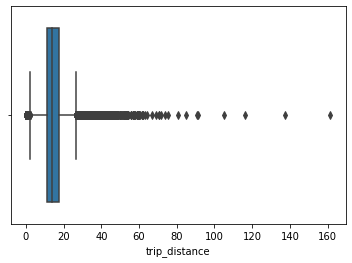

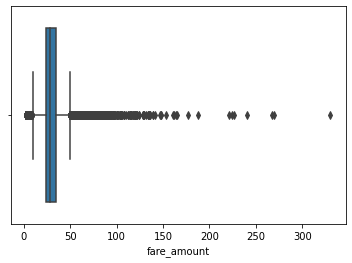

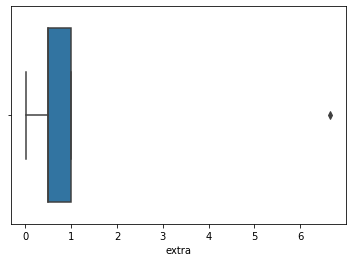

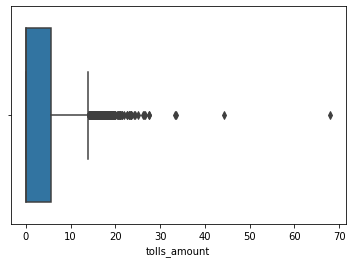

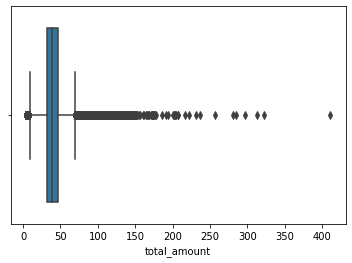

In [33]:
df = df.loc[(df[['extra', "fare_amount", "total_amount", "tip_amount"]] > 0).all(axis=1)] #Remove negative values for price
for column in df[["trip_distance","fare_amount", "extra", "tolls_amount", "total_amount"]]: #Checking outliers
  plt.figure()
  sns.boxplot(df[column])

It seems we have some outliers indeed! Let's use the interquatile method to remove them :

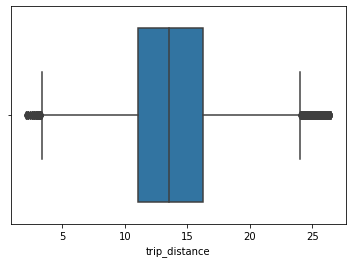

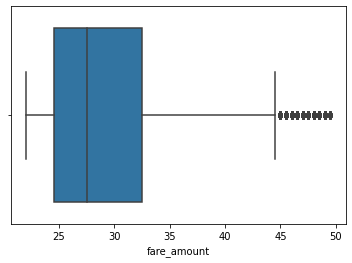

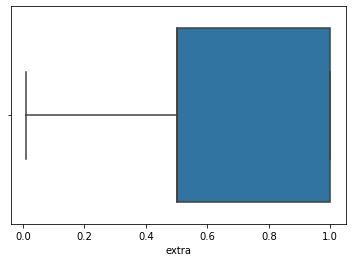

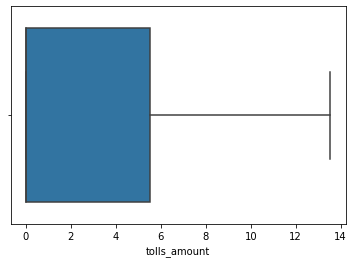

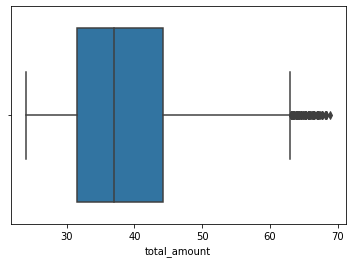

In [34]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df = df[df["fare_amount"]>15]
for column in df[["trip_distance","fare_amount", "extra", "tolls_amount", "total_amount"]]:
  plt.figure()
  sns.boxplot(df[column])

That's it, no more outliers! Let's compute some additional variables, namely the year of the trip, and its duration.

In [35]:
#Let's convert the payment_type into dummies variables, and compute the duration of the trip.
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"]) #Converting the date into datetime type
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])
df["year"] = df["pickup_datetime"].dt.year #Let's extract the year as well. 
df["duration"] = (df['dropoff_datetime']-df['pickup_datetime']).dt.total_seconds()/60 #Compute the duration

Let's create the final dataframe

In [36]:
df_final = df.copy()
print(df_final.describe())
df_final.head()

          vendor_id  passenger_count  trip_distance  pickup_longitude  \
count  45974.000000     45974.000000   45974.000000      34198.000000   
mean       1.497390         1.263627      13.787091        -73.955714   
std        0.499999         0.535451       3.882510          0.052924   
min        1.000000         0.000000       2.076054        -74.018105   
25%        1.000000         1.000000      11.072290        -73.992676   
50%        1.000000         1.000000      13.566774        -73.980347   
75%        2.000000         1.000000      16.254379        -73.885345   
max        2.000000         3.000000      26.441530        -73.711197   

       pickup_latitude  rate_code  dropoff_longitude  dropoff_latitude  \
count     34198.000000    34648.0       34198.000000      34198.000000   
mean         40.752322        1.0         -73.952703         40.744090   
std           0.023873        0.0           0.042894          0.057378   
min          40.666691        1.0         -74.

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,year,duration
5,1,2015-11-15 21:30:58,2015-11-15 21:55:47,1,24.301102,-73.874443,40.773983,1.0,N,-74.017311,...,1,42.0,0.5,0.5,9.76,5.54,0.3,58.60,2015,24.816667
6,2,2015-01-08 19:28:42,2015-01-08 19:46:40,1,13.615054,-73.862740,40.769081,NaN,N,-73.952225,...,1,25.5,1.0,0.5,6.37,5.33,0.3,39.00,2015,17.966667
11,2,2015-08-15 00:53:16,2015-08-15 01:09:09,1,12.810382,-73.956306,40.707939,1.0,N,-73.967697,...,1,23.5,0.5,0.5,4.96,0.00,0.3,29.76,2015,15.883333
12,1,2015-05-17 00:10:38,2015-05-17 00:45:43,2,14.966904,-73.980515,40.676228,NaN,N,-73.950478,...,1,32.0,0.5,0.5,6.65,0.00,0.3,39.95,2015,35.083333
13,2,2015-05-26 16:42:18,2015-05-26 17:17:21,1,9.269824,-73.991913,40.745750,NaN,N,-73.963730,...,1,25.5,1.0,0.5,5.46,0.00,0.3,32.76,2015,35.050000


Hmmm. Apparently, some variables are almost constant... Let's check this out.

,Desc,Var,Value,Perc
0,Constant,payment_type,1,100.000000
1,Constant,mta_tax,0.5,100.000000
2,Constant,imp_surcharge,0.3,100.000000
3,Quasi Constant,store_and_fwd_flag,N,99.049463


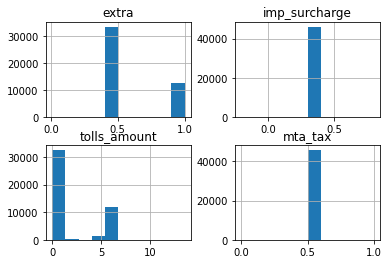

In [37]:
df_final.hist(column=["extra", "imp_surcharge", "tolls_amount", "mta_tax"])
get_constant_features(df_final) 

Indeed, constants! We'll not consider the mta_tax, payment_type and imp_surchage variables.

# Model preparation

In [38]:
X = df_final[["trip_distance", "tip_amount", "passenger_count", "duration", "tolls_amount", "extra"]]
Y = df_final[["fare_amount"]]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data #We have a multicollinearity problem. Dang! Let's do the simple model, and then try to do some ridge regression to penalize less important features.

,feature,VIF
0,trip_distance,14.919825
1,tip_amount,16.893413
2,passenger_count,5.383289
3,duration,1.476626
4,tolls_amount,1.667135
5,extra,7.125002


In [78]:
X_train,X_test, Y_train, Y_test = train_test_split(X, Y,  test_size=0.33, random_state=1962)
sc = StandardScaler()
X_train = sc.fit_transform(X_train) #Standardize data
X_test = sc.transform(X_test)

In [79]:
reg = LinearRegression().fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
print("RMSE %.5f" % mean_squared_error(Y_test, Y_pred))
print("R²: %.5f" % r2_score(Y_test, Y_pred))
Adj_r2 = 1 - (1-r2_score(Y_test, Y_pred)) * (len(Y)-1)/(len(Y)-X.shape[1]-1) #*
print("Adjusted R²: %.5f" % Adj_r2)

RMSE 8.23280
R²: 0.75180
Adjusted R²: 0.75176


In [80]:
rdgr = Ridge(alpha=100)
reg_rdgr = rdgr.fit(X_train, Y_train)
Y_pred2 = reg_rdgr.predict(X_test)
print("RMSE %.5f" % mean_squared_error(Y_test, Y_pred2))
print("R²: %.5f" % r2_score(Y_test, Y_pred2))
Adj_r2 = 1 - (1-r2_score(Y_test, Y_pred2)) * (len(Y)-1)/(len(Y)-X.shape[1]-1) 
print("Adjusted R²: %.5f" % Adj_r2)

RMSE 8.23267
R²: 0.75180
Adjusted R²: 0.75177


Ridge

In [52]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1962)
model = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')# perform the search
results = model.fit(X_train, Y_train)
# summarize
print('MAE: %.5f' % results.best_score_)
print('Best alpha: %.5f' % model.alpha_)

MAE: -2.12292
Best alpha: 0.00000


In [52]:
# Optimization ###
params = {'n_estimators': 1000, 'max_depth': 5, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
gbr = ensemble.GradientBoostingRegressor(**params)
gbr.fit(X_train, Y_train)
Y_pred3 = gbr.predict(X_test)
print("RMSE %.5f" % mean_squared_error(Y_test, Y_pred3))
print("R²: %.5f" % r2_score(Y_test, Y_pred3))
Adj_r2 = 1 - (1-r2_score(Y_test, Y_pred3)) * (len(Y)-1)/(len(Y)-X.shape[1]-1) #A RECHECK !!!
print("Adjusted R²: %.5f" % Adj_r2) #Same R²...

RMSE 0.63690
R²: 0.98080
Adjusted R²: 0.98080


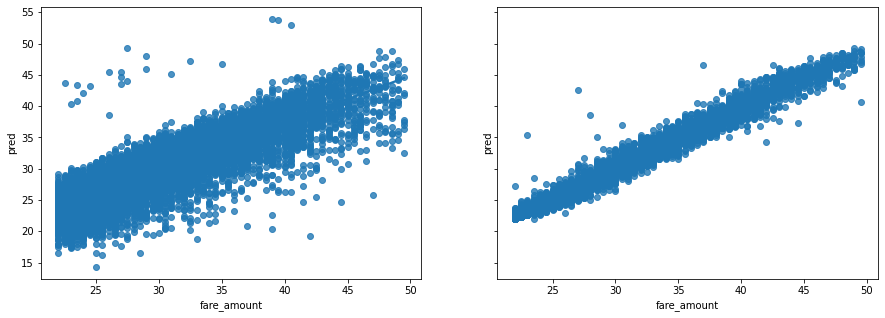

In [84]:
yo1 = Y_test.copy()
yo1["pred"] = list(Y_pred.ravel())

yo = Y_test.copy()
yo["pred"] = list(Y_pred3.ravel())
Fig,Ax = plt.subplots(ncols=2, figsize=(15,5), sharex=True, sharey=True)
sns.regplot(x=yo1["fare_amount"], y=yo1["pred"], ax=Ax[0])
sns.regplot(x=yo["fare_amount"], y=yo["pred"], ax=Ax[1])
plt.show()

TO DO: Add boroughs and see if there is any effects of particular areas...

In [ ]:
import folium
from folium import plugins
m = folium.Map([40.773983, -73.874443, ], zoom_start=10.5)
"""
for index, row in df.iterrows():
    folium.CircleMarker([row['pickup_latitude'], row['pickup_longitude']],
                        radius=1,
                       ).add_to(m)
"""
stationArr = df[['pickup_latitude', 'pickup_longitude']].values

# plot heatmap
m.add_children(plugins.HeatMap(stationArr, radius=15))
m

In [ ]:
n = folium.Map([40.773983, -73.874443, ], zoom_start=10.5)
"""
for index, row in df.iterrows():
    folium.CircleMarker([row['pickup_latitude'], row['pickup_longitude']],
                        radius=1,
                       ).add_to(m)
"""
stationArr = df[['dropoff_latitude', 'dropoff_longitude']].values

# plot heatmap
n.add_children(plugins.HeatMap(stationArr, radius=15))
n

In [ ]:
https://rstudio-pubs-static.s3.amazonaws.com/414401_4e3c51fe17bc4a8f839824b88dee2e6b.html 
https://medium.com/@saidakbarp/interactive-map-visualization-with-folium-in-python-2e95544d8d9b